# Hypothesis Testing

## 1. Introduction

We will construct a hypothesis test to determine whether the extreme volatility seen in certain months for the FTSE 100 Index really is significant and therefore likely to continue, or whether it could simply happen by chance. 

## 2. Install/import libraries

In [11]:
!pip install seaborn

In [12]:
!pip install yfinance

In [13]:
!pip install mplfinance

In [14]:
!pip install pandas_datareader

In [15]:

import numpy as np
import seaborn as sns
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.patches as mpatches
from matplotlib.dates import date2num, DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from mplfinance.original_flavor import candlestick_ohlc
import seaborn as sns
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['figure.facecolor'] = '#00000000'
plt.rcParams['lines.linewidth'] = 2
import datetime
from datetime import date, timedelta
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

## 3. Import data

In [16]:

nifty50_2007_to_2023 = yf.download("^NSEI", start=datetime.datetime(2007, 9, 17), 
                                     end=datetime.datetime(2023, 3, 31))
nifty50_2007_to_2023

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0
...,...,...,...,...,...,...
2023-03-23,17097.400391,17205.400391,17045.300781,17076.900391,17076.900391,219200
2023-03-24,17076.199219,17109.449219,16917.349609,16945.050781,16945.050781,228000
2023-03-27,16984.300781,17091.000000,16918.550781,16985.699219,16985.699219,218400


In [17]:
nifty50_2007_to_2023.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0


## 4. Plot FTSE 100 Close prices 

We will plot the raw daily close price data for the FTSE 100 Index from 1984-2020 showing major market events.

ConversionError: Failed to convert value(s) to axis units: array([Timestamp('2007-09-17 00:00:00'), Timestamp('2007-09-18 00:00:00'),
       Timestamp('2007-09-19 00:00:00'), ...,
       Timestamp('2023-03-27 00:00:00'), Timestamp('2023-03-28 00:00:00'),
       Timestamp('2023-03-29 00:00:00')], dtype=object)

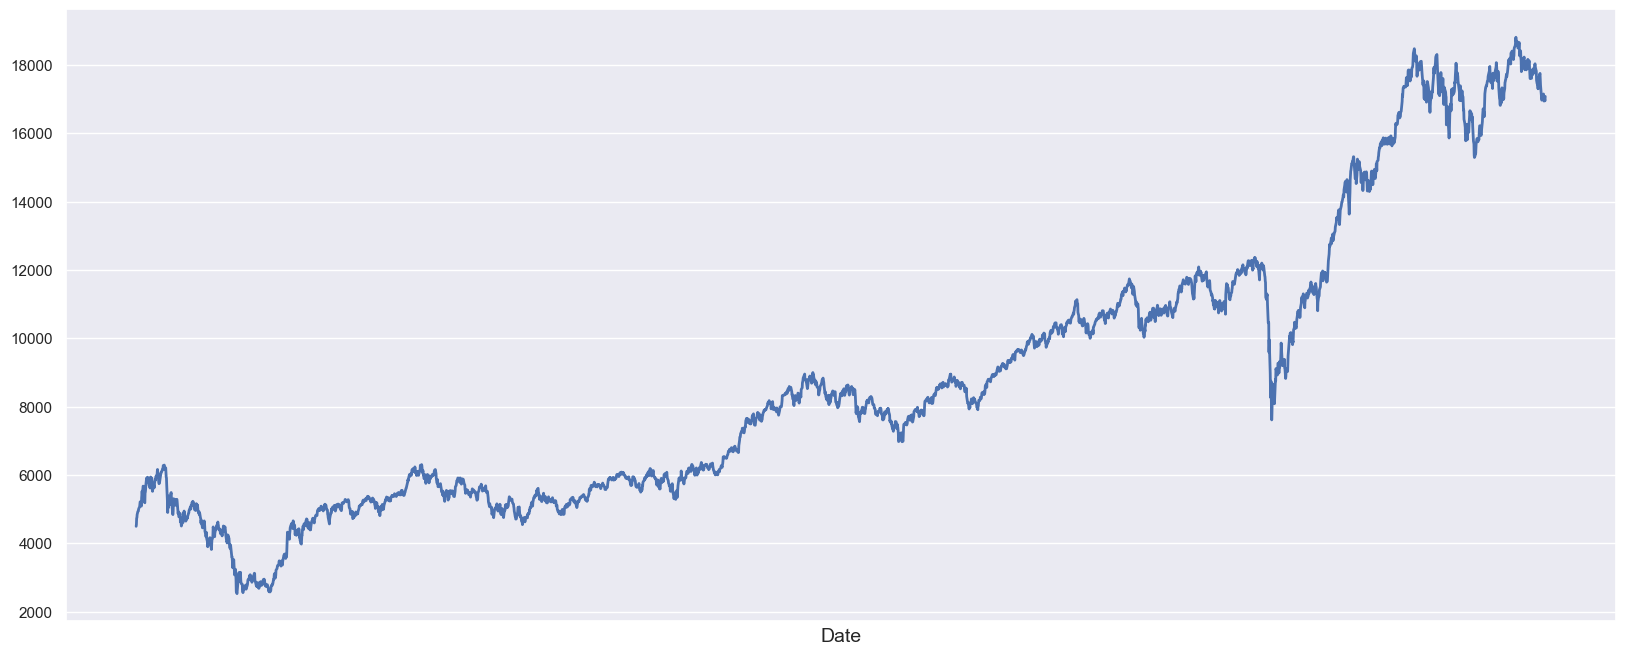

In [18]:
def nifty50_2007_to_2023_plot():
    nifty50_2007_to_2023['Close'].plot(grid = True)
    sns.set(rc={'figure.figsize':(20, 10)})
    plt.axvspan('2008','2010',color='r',alpha=.5)
    plt.axvspan('2020','2021',color='r',alpha=.5)
    labs = mpatches.Patch(color='red',alpha=.5, label="2008 Crash & Covid-19 Crash")
    plt.legend(handles=[labs], prop={"size":15},  bbox_to_anchor=(0.4, 0.1), loc='upper center', borderaxespad=0.)
    plt.title('Close Price for Nifty50 Index', color = 'black', fontsize = 20)
    plt.xlabel('Year', color = 'black', fontsize = 15)
    plt.ylabel('Close Price', color = 'black', fontsize = 15)
    plt.show();

nifty50_2007_to_2023_plot()

## 5. Data transformation

We need to transform the raw close price data into a format that shows the phenomena we are investigating - average monthly volatility rankings (AMVR).

### 5.1 Percentage change

We will use the pandas method 'pct_change()' to calculate the daily percentage change directly.

In [19]:
# To model returns we will use pct_change() to compute the percentage change from the previous row by default.
daily_returns = nifty50_2007_to_2023['Close'].pct_change()
# Drop the first value which becomes a 'NaN' as there is no price change from the day before.
daily_returns.dropna(inplace=True)
# Daily precentage change
daily_returns.head()

Date
2007-09-18    0.011469
2007-09-19    0.040946
2007-09-20    0.003212
2007-09-21    0.018957
2007-09-24    0.019566
Name: Close, dtype: float64

### 5.2 Resample returns

We will use pandas resample() method to change the frequency of our data from daily to monthly and use standard deviation as
a measure of volatility.

In [20]:
# Resample returns per month and take Standard Dev as measure of volatility
# then annualise by multiplying by sqrt of number of periods (12)
mnthly_annu = daily_returns.resample('M').std()* np.sqrt(12)

mnthly_annu.head()

Date
2007-09-30    0.044668
2007-10-31    0.085934
2007-11-30    0.061786
2007-12-31    0.057705
2008-01-31    0.113138
Freq: M, Name: Close, dtype: float64

### 5.3 Plot returns

We can plot the annualised monthly volatility to show the major market events. 

ConversionError: Failed to convert value(s) to axis units: array([Period('2007-09', 'M'), Period('2007-10', 'M'),
       Period('2007-11', 'M'), Period('2007-12', 'M'),
       Period('2008-01', 'M'), Period('2008-02', 'M'),
       Period('2008-03', 'M'), Period('2008-04', 'M'),
       Period('2008-05', 'M'), Period('2008-06', 'M'),
       Period('2008-07', 'M'), Period('2008-08', 'M'),
       Period('2008-09', 'M'), Period('2008-10', 'M'),
       Period('2008-11', 'M'), Period('2008-12', 'M'),
       Period('2009-01', 'M'), Period('2009-02', 'M'),
       Period('2009-03', 'M'), Period('2009-04', 'M'),
       Period('2009-05', 'M'), Period('2009-06', 'M'),
       Period('2009-07', 'M'), Period('2009-08', 'M'),
       Period('2009-09', 'M'), Period('2009-10', 'M'),
       Period('2009-11', 'M'), Period('2009-12', 'M'),
       Period('2010-01', 'M'), Period('2010-02', 'M'),
       Period('2010-03', 'M'), Period('2010-04', 'M'),
       Period('2010-05', 'M'), Period('2010-06', 'M'),
       Period('2010-07', 'M'), Period('2010-08', 'M'),
       Period('2010-09', 'M'), Period('2010-10', 'M'),
       Period('2010-11', 'M'), Period('2010-12', 'M'),
       Period('2011-01', 'M'), Period('2011-02', 'M'),
       Period('2011-03', 'M'), Period('2011-04', 'M'),
       Period('2011-05', 'M'), Period('2011-06', 'M'),
       Period('2011-07', 'M'), Period('2011-08', 'M'),
       Period('2011-09', 'M'), Period('2011-10', 'M'),
       Period('2011-11', 'M'), Period('2011-12', 'M'),
       Period('2012-01', 'M'), Period('2012-02', 'M'),
       Period('2012-03', 'M'), Period('2012-04', 'M'),
       Period('2012-05', 'M'), Period('2012-06', 'M'),
       Period('2012-07', 'M'), Period('2012-08', 'M'),
       Period('2012-09', 'M'), Period('2012-10', 'M'),
       Period('2012-11', 'M'), Period('2012-12', 'M'),
       Period('2013-01', 'M'), Period('2013-02', 'M'),
       Period('2013-03', 'M'), Period('2013-04', 'M'),
       Period('2013-05', 'M'), Period('2013-06', 'M'),
       Period('2013-07', 'M'), Period('2013-08', 'M'),
       Period('2013-09', 'M'), Period('2013-10', 'M'),
       Period('2013-11', 'M'), Period('2013-12', 'M'),
       Period('2014-01', 'M'), Period('2014-02', 'M'),
       Period('2014-03', 'M'), Period('2014-04', 'M'),
       Period('2014-05', 'M'), Period('2014-06', 'M'),
       Period('2014-07', 'M'), Period('2014-08', 'M'),
       Period('2014-09', 'M'), Period('2014-10', 'M'),
       Period('2014-11', 'M'), Period('2014-12', 'M'),
       Period('2015-01', 'M'), Period('2015-02', 'M'),
       Period('2015-03', 'M'), Period('2015-04', 'M'),
       Period('2015-05', 'M'), Period('2015-06', 'M'),
       Period('2015-07', 'M'), Period('2015-08', 'M'),
       Period('2015-09', 'M'), Period('2015-10', 'M'),
       Period('2015-11', 'M'), Period('2015-12', 'M'),
       Period('2016-01', 'M'), Period('2016-02', 'M'),
       Period('2016-03', 'M'), Period('2016-04', 'M'),
       Period('2016-05', 'M'), Period('2016-06', 'M'),
       Period('2016-07', 'M'), Period('2016-08', 'M'),
       Period('2016-09', 'M'), Period('2016-10', 'M'),
       Period('2016-11', 'M'), Period('2016-12', 'M'),
       Period('2017-01', 'M'), Period('2017-02', 'M'),
       Period('2017-03', 'M'), Period('2017-04', 'M'),
       Period('2017-05', 'M'), Period('2017-06', 'M'),
       Period('2017-07', 'M'), Period('2017-08', 'M'),
       Period('2017-09', 'M'), Period('2017-10', 'M'),
       Period('2017-11', 'M'), Period('2017-12', 'M'),
       Period('2018-01', 'M'), Period('2018-02', 'M'),
       Period('2018-03', 'M'), Period('2018-04', 'M'),
       Period('2018-05', 'M'), Period('2018-06', 'M'),
       Period('2018-07', 'M'), Period('2018-08', 'M'),
       Period('2018-09', 'M'), Period('2018-10', 'M'),
       Period('2018-11', 'M'), Period('2018-12', 'M'),
       Period('2019-01', 'M'), Period('2019-02', 'M'),
       Period('2019-03', 'M'), Period('2019-04', 'M'),
       Period('2019-05', 'M'), Period('2019-06', 'M'),
       Period('2019-07', 'M'), Period('2019-08', 'M'),
       Period('2019-09', 'M'), Period('2019-10', 'M'),
       Period('2019-11', 'M'), Period('2019-12', 'M'),
       Period('2020-01', 'M'), Period('2020-02', 'M'),
       Period('2020-03', 'M'), Period('2020-04', 'M'),
       Period('2020-05', 'M'), Period('2020-06', 'M'),
       Period('2020-07', 'M'), Period('2020-08', 'M'),
       Period('2020-09', 'M'), Period('2020-10', 'M'),
       Period('2020-11', 'M'), Period('2020-12', 'M'),
       Period('2021-01', 'M'), Period('2021-02', 'M'),
       Period('2021-03', 'M'), Period('2021-04', 'M'),
       Period('2021-05', 'M'), Period('2021-06', 'M'),
       Period('2021-07', 'M'), Period('2021-08', 'M'),
       Period('2021-09', 'M'), Period('2021-10', 'M'),
       Period('2021-11', 'M'), Period('2021-12', 'M'),
       Period('2022-01', 'M'), Period('2022-02', 'M'),
       Period('2022-03', 'M'), Period('2022-04', 'M'),
       Period('2022-05', 'M'), Period('2022-06', 'M'),
       Period('2022-07', 'M'), Period('2022-08', 'M'),
       Period('2022-09', 'M'), Period('2022-10', 'M'),
       Period('2022-11', 'M'), Period('2022-12', 'M'),
       Period('2023-01', 'M'), Period('2023-02', 'M'),
       Period('2023-03', 'M')], dtype=object)

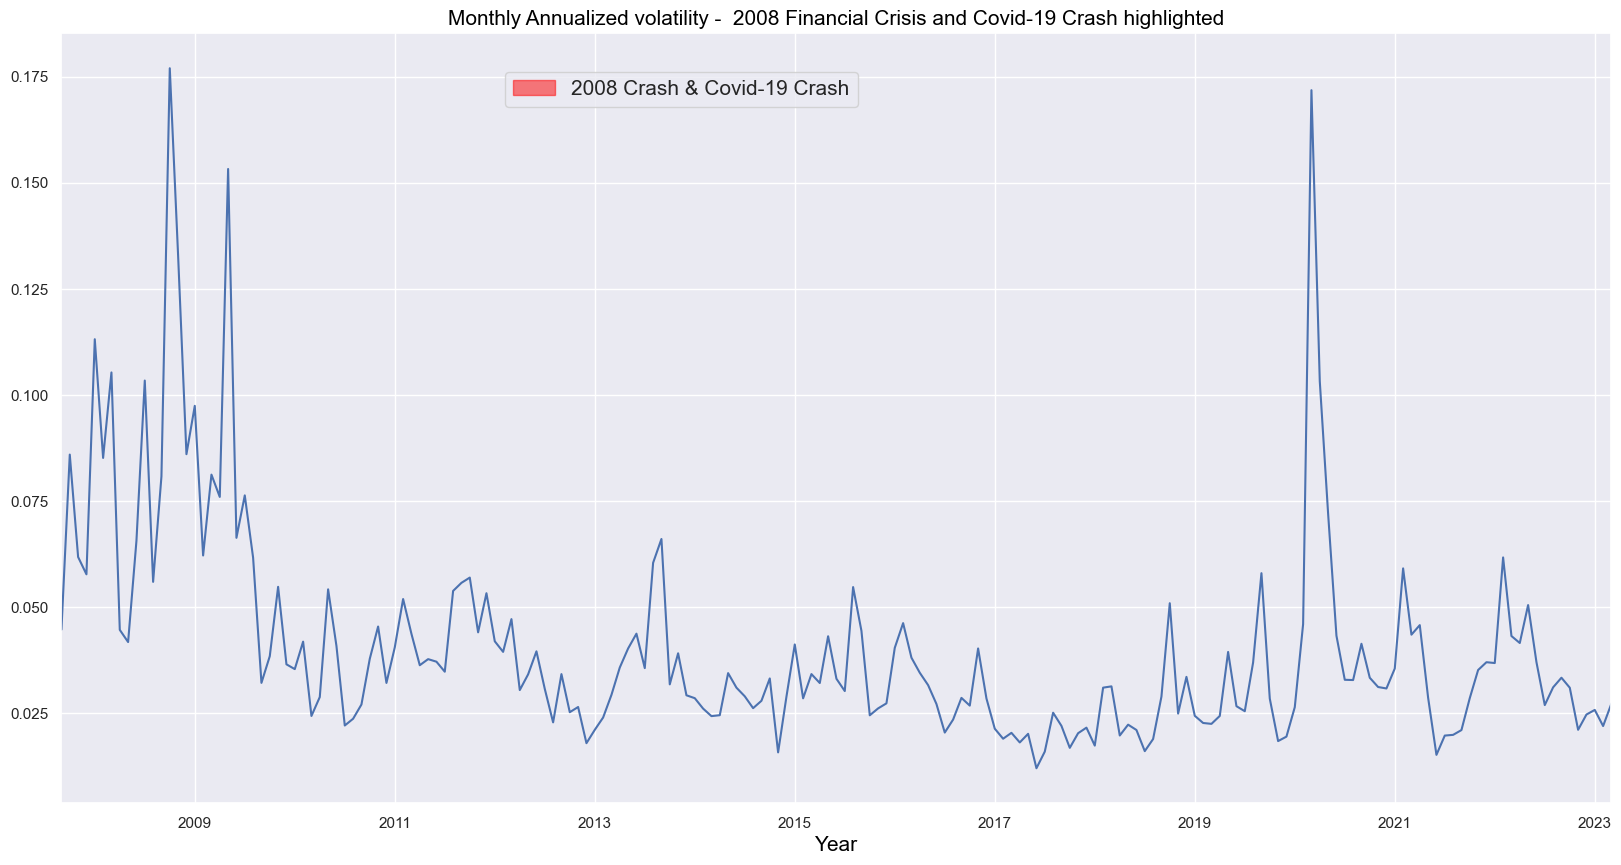

In [21]:
# We can see the major market events show up in the volatility

def nifty50_2007_to_2023_mnth():
    mnthly_annu.plot(grid = True)
    sns.set(rc={'figure.figsize':(15, 5)})
    # plt.axvspan('1987','1989',color='r',alpha=.5)
    
    # plt.axvspan('2020','2021',color='r',alpha=.5)
    labs = mpatches.Patch(color='red',alpha=.5, label="2008 Crash & Covid-19 Crash")
    plt.legend(handles=[labs], prop={"size":15},  bbox_to_anchor=(0.4, 0.95), loc='upper center', borderaxespad=0.)
    plt.title('Monthly Annualized volatility -  2008 Financial Crisis and Covid-19 Crash highlighted', color = 'black', fontsize = 15)
    plt.xlabel('Year', color = 'black', fontsize = 15)
    plt.axvspan('2008','2010',color='r',alpha=.5)
    plt.show();

nifty50_2007_to_2023_mnth()

### 5.4 Calculate Annual Monthly Volatility Rankings (AMVR) metric

We can achieve the AMVR values by applying the pandas groupby() method to the mnthly_annu values and passing in 'mnthly_annu.index.year', which is the year attribute on the datatime index of the mnthly_annu data. 

Next we apply the rank() method, which orders the data in ascending order.

We repeat the process and average over all years for each month to reach the final AMVR values.

In [22]:
# Group volatility by year and create a ranking for each of the 12 months over all 37 years of data

# for each year rank each month based on volatility lowest=1 highest=12
ranked = mnthly_annu.groupby(mnthly_annu.index.year).rank()

# average the ranks over all years for each month
final = ranked.groupby(ranked.index.month).mean()

final.describe()

count    12.000000
mean      6.338194
std       1.062475
min       4.400000
25%       5.809375
50%       6.322917
75%       7.062500
max       8.266667
Name: Close, dtype: float64

In [23]:
# This gives our final Average Monthly Volatility Rankings. 
# the final average results over 37 years 

final

Date
1     6.687500
2     7.062500
3     7.437500
4     6.000000
5     8.266667
6     6.333333
7     4.400000
8     5.933333
9     7.062500
10    6.312500
11    5.437500
12    5.125000
Name: Close, dtype: float64

Numerically we can see that month 5 (May) is the most volatile and 12 (December) is the least volatile. 

### 5.5 Plot AMVR values

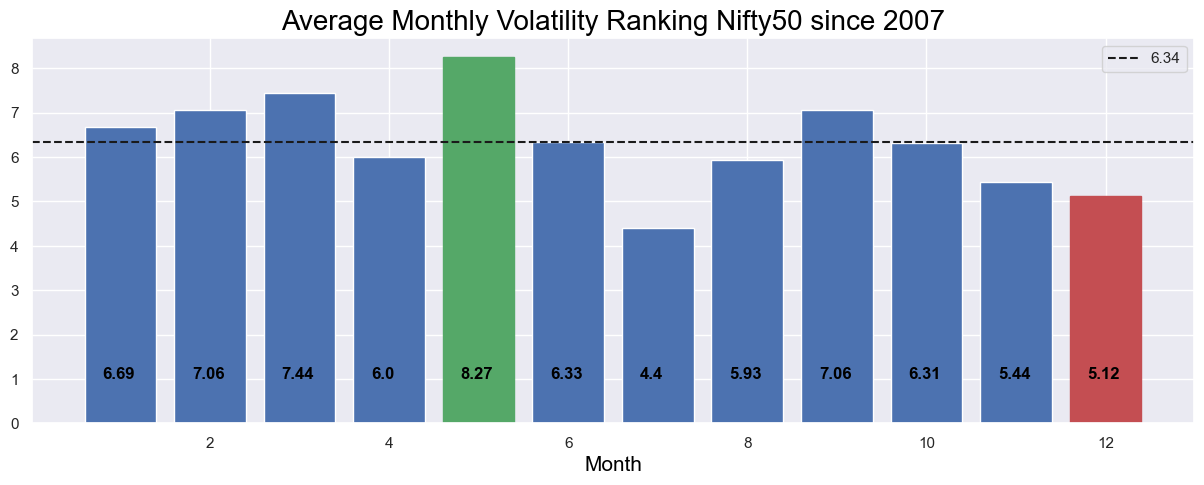

In [24]:
# Plot results for ranked Nifty50 volatility

b_plot = plt.bar(x=final.index,height=final)
b_plot[4].set_color('g')
b_plot[11].set_color('r')
for i,v in enumerate(round(final,2)):
    plt.text(i+.8,1,str(v), color='black', fontweight='bold')
plt.axhline(final.mean(),ls='--',color='k',label=round(final.mean(),2))
plt.title('Average Monthly Volatility Ranking Nifty50 since 2007', color = 'black', fontsize = 20)
plt.xlabel('Month', color = 'black', fontsize = 15)
plt.legend()
plt.show()

Clearly we can see that May has the highest AMVR and December has the lowest. The mean of 6.34 is also plotted.

## 6. Hypothesis Testing

We wish to test “whether the observed effect in our data is real or whether it could happen simply by chance”.

To perform this test we do the following:

*   Choose an appropriate ‘test statistic’
*   Construct a Null Hypothesis
*   Compute a p-value


### 6.1 Choose an appropriate ‘test statistic’

This is simply a number that measures the observed effect. In our case, we will choose the **absolute deviation in AMVR from the mean**.

The question we are trying to answer is "Could the most extreme value happen by chance?" and we can now define the most extreme value as the greatest absolute AMVR deviation from the mean.

In [ ]:
# Take abs value move from the mean

fin = abs(final - final.mean())
print(fin.sort_values())
July_value = fin[7]
May_value = fin[5]
print('Extreme July value:', July_value)
print('Extreme May value:', May_value)

Date
6     0.004861
10    0.025694
4     0.338194
1     0.349306
8     0.404861
2     0.724306
9     0.724306
11    0.900694
3     1.099306
12    1.213194
5     1.928472
7     1.938194
Name: Close, dtype: float64
Extreme July value: 1.938194444444444
Extreme May value: 1.928472222222223


In our data, the most extreme value is the July value (1.93) followed by the May value (1.92). Here, July has the most significant absolute deviation from the mean, as well as the highest volatility. However, it could have been the case that the month with the most significant absolute deviation from the mean was different from the month with the highest volatility.

### 6.2. Construct a Null Hypothesis

The null hypothesis is that there is no seasonality in the data and the observed effect was simply by chance or, alternatively, that the month does not matter in terms of AMVR.

To get the desired null model, we need to construct a dataset that has no seasonality present. This will make the observed effect (the extreme October value) equally likely for all months.

We can generate this simulated dataset by shuffling the 'daily' return data repeatedly, which has the same effect as shuffling 'month' labels so that if the null hypothesis is true, then the labels for each month (Jan, Feb, etc) are meaningless. The simulated dataset is known as the 'sampling distribution of the test statistic under the null hypothesis'.



In [ ]:
# Dataset has 3807 values

daily_returns

Date
2007-09-18    0.011469
2007-09-19    0.040946
2007-09-20    0.003212
2007-09-21    0.018957
2007-09-24    0.019566
                ...   
2023-03-23   -0.004373
2023-03-24   -0.007721
2023-03-27    0.002399
2023-03-28   -0.002002
2023-03-29    0.007610
Name: Close, Length: 3807, dtype: float64

### Simulation through resampling

In [ ]:
# Simulate data to create a null dataset

new_df_sim = pd.DataFrame()
highest_only = []

count=0
n=1000
for i in range(n):
    # randomly sample from daily returns same size as dataset, drop timestamp 
    daily_returns_shuffle = daily_returns.sample(3807).reset_index(drop=True)
    #add new timestamp to shuffled data
    daily_returns_shuffle.index = (pd.bdate_range(start='2007-9-17',periods=3807))
    
    #then follow same data wrangling as before
    mnthly_annu = daily_returns_shuffle.resample('M').std()* np.sqrt(12)
    
    ranked = mnthly_annu.groupby(mnthly_annu.index.year).rank()
    sim_final = ranked.groupby(ranked.index.month).mean()
    #add each of 1000 sims into df
    new_df_sim = pd.concat([new_df_sim,sim_final],axis=1)
    
    #also record just highest AMVR for each year 
    maxi_month = max(sim_final)
    highest_only.append(maxi_month)
    

    
#calculate absolute deviation in AMVR from the mean
all_months = new_df_sim.values.flatten()
mu_all_months = all_months.mean()
abs_all_months = abs(all_months-mu_all_months)    

#calculate absolute deviation in highest only AMVR from the mean
mu_highest = np.mean(highest_only)
abs_highest = [abs(x - mu_all_months) for x in highest_only]

### 6.3 Compute a p-value

The p-value is the probability of seeing the observed effect amongst the null data, in other words, by chance. 

Now we need to perform our hypothesis test to find the probability of observing a result as significant as the October result given that the null hypothesis (no seasonality) is true.

### What is the probability that May and July would appear this extreme by chance?

To compute the p-value we count how many values in our dataset using all 12000 AMVR deviations (12 months x 1000 trials) are greater than the observed May and July value.

In [ ]:
# Count number of months in simulated data where AMVR deviation is > May
# comparing against all months
# We are using Oct, as it has highest absolute deviation from the mean
count=0
for i in abs_all_months:
    if i> May_value:
        count+=1
ans = count/len(abs_all_months)        
print('p-value:', ans )

p-value: 0.03


In [ ]:
# Count number of months in simulated data where AMVR deviation is > July
# comparing against all months
# We are using Oct, as it has highest absolute deviation from the mean
count=0
for i in abs_all_months:
    if i> July_value:
        count+=1
ans = count/len(abs_all_months)        
print('p-value:', ans )

p-value: 0.03


We get a p-value of 14.9%, higher than our 5% cut off, and so not significant. Although in this case the result was not significant, the problem with this approach is that it manipulates the data in a way that could produce a desired p-value. By expanding our search space to all months we increase the likelihood of finding a significant result. This is known as p-hacking.

### What is the probability any month would appear this extreme by chance?

To reduce the effect of multiple comparison bias, instead of comparing our result to the distribution made with all 12000 AMVR deviations, which assumes we are testing for a significant result against all 12 months, we will only consider the highest value from each of the absolute AMVR 1000 trials.  

In [ ]:
# Count number of months in simulated data where AMVR deviation is > July
# but just considering highest AMVR for each of 1000 trials
count=0
for i in abs_highest:
    if i> May_value:
        count+=1
ans = count/len(abs_highest)        
print('p-value:', ans )

p-value: 0.191


This gives a p-value of 19.1%, not at all significant!

## Plot the two distributions

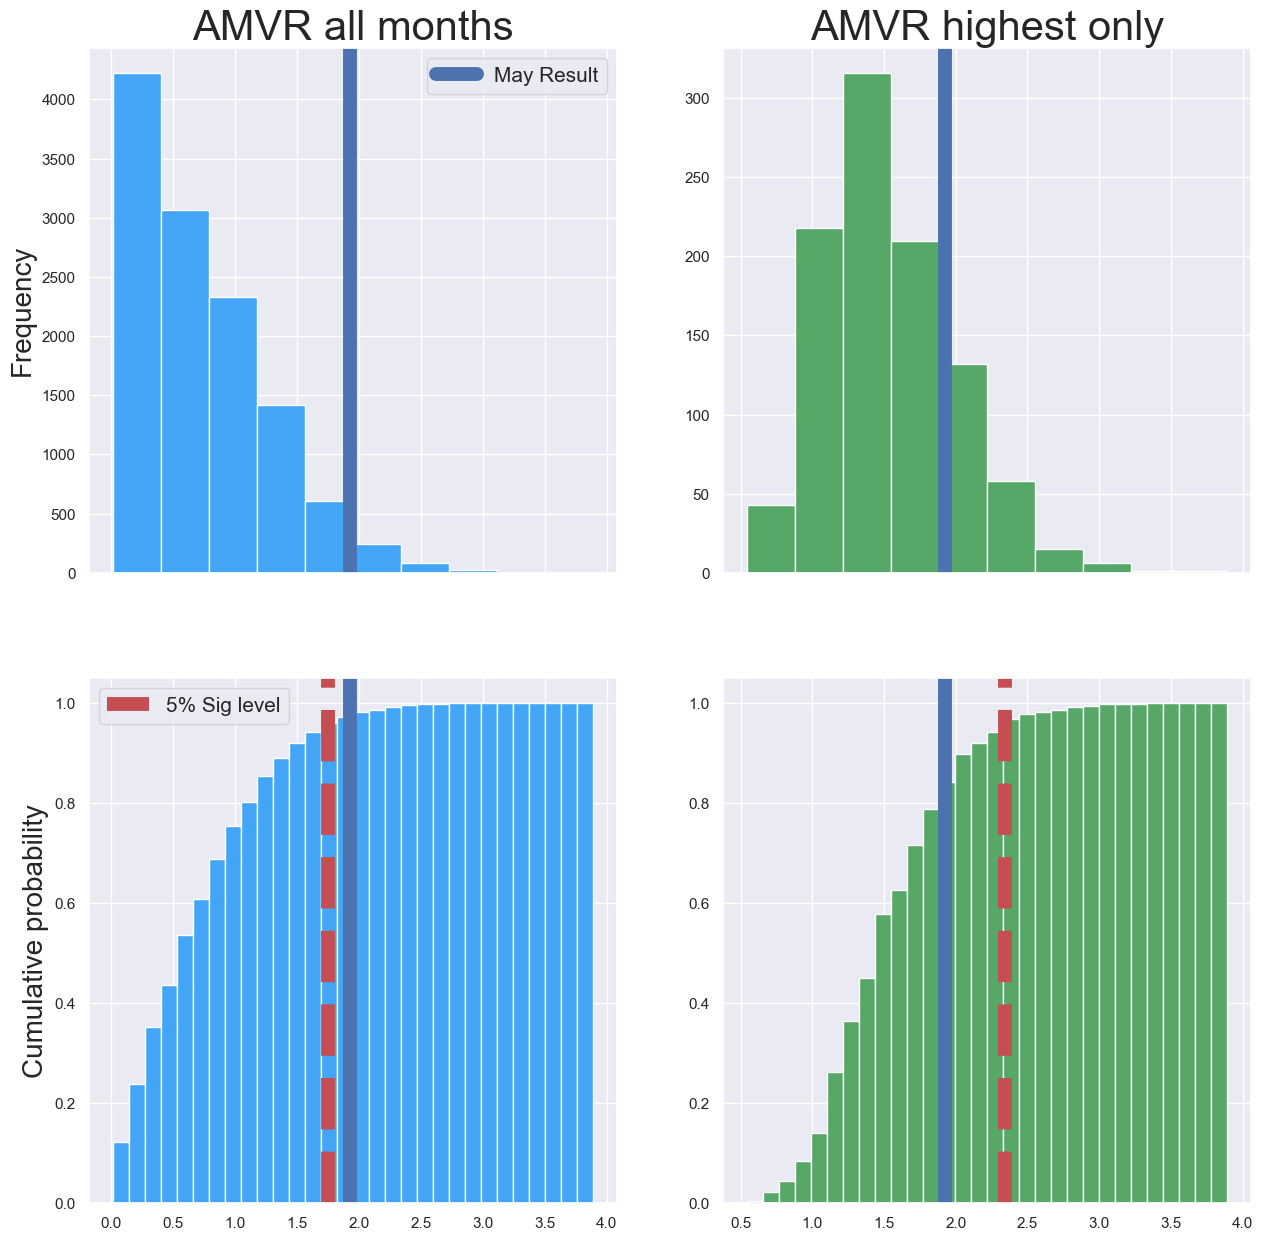

In [ ]:
# Calculate 5% significance
abs_all_months_95 = np.quantile(abs_all_months,.95)
abs_highest_95 = np.quantile(abs_highest,.95)

# Plot AMVR all months in left column and AMVR highest only in right column
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex='col',figsize=(15,15))


#plot 1 AMVR all months
ax1.hist(abs_all_months,histtype='bar',color='#42a5f5')
ax1.set_title('AMVR all months',fontsize=30)
ax1.set_ylabel('Frequency',fontsize=20)
n,bins,patches = ax3.hist(abs_all_months,density=1,histtype='bar',cumulative=True,bins=30,color='#42a5f5')
ax3.set_ylabel('Cumulative probability',fontsize=20)
ax1.axvline(May_value,color='b',label='May Result',lw=10)
ax3.axvline(May_value,color='b',lw=10)
ax3.axvline(abs_all_months_95,color='r',ls='--',label='5% Sig level',lw=10)


#plot 2 AMVR highest only
ax2.hist(abs_highest,histtype='bar',color='g')
ax2.set_title('AMVR highest only',fontsize=30)
ax2.axvline(May_value,color='b',lw=10)
n,bins,patches = ax4.hist(abs_highest,density=1,histtype='bar',cumulative=True,bins=30,color='g')
ax4.axvline(May_value,color='b',lw=10)
ax4.axvline(abs_highest_95,color='r',ls='--',lw=10)

ax1.legend(fontsize=15)
ax3.legend(fontsize=15);

The plots in the left column show the AMVR all months data which answers the question: *What is the probability that May would appear this extreme by chance?* The plots in the right column show the AMVR all months data which answers the question: *What is the probability any month would appear this extreme by chance?*

The top row shows the probability distributions, and the bottom row shows the cumulative distribution function (CDF). The red dashed line is the 5% significance level and the blue line is the original extreme May AMVR value of 2.0.

The left side plot shows that the original May value is significant being higher than the 5% level. However, when we account for multiple comparison bias, in the right-hand plot the threshold for significance moves up from around 1.8 (abs AMVR) up to around 2.4 (see the red dashed line). By accounting for multiple comparison bias, the May value of 2.0 is considerable significant.

To conclude, we have proven to reject the null hypothesis indicating that our sample did provide sufficient evidence to conclude that the effect (the extreme May value happening by chance) exists.